In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [31]:
# Fetch historical price data using yfinance
ticker = "AMZN"
start_date = "2011-01-01"
end_date = "2023-01-01"

data = yf.download(ticker, start=start_date, end=end_date)
df = data[['Open', 'High', 'Low', 'Close']].copy()

[*********************100%***********************]  1 of 1 completed


In [32]:
# Calculate MACD
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

calculate_macd(df)

In [33]:
# Identify Double Top pattern
def identify_double_top(df, lookback=5):
    df['High_shifted'] = df['High'].shift(1)
    df['Low_shifted'] = df['Low'].shift(1)
    df['Double_Top'] = ((df['High'] > df['High_shifted']) &
                        (df['High_shifted'] < df['High_shifted'].shift(1)) &
                        (df['Low'] < df['Low_shifted']))
    df.drop(['High_shifted', 'Low_shifted'], axis=1, inplace=True)

identify_double_top(df)

In [34]:
# Implement trading strategy
capital = 100000  # Initial capital
position = 0  # 0 for no position, 1 for long position
stop_loss = 0  # Stop-loss level
take_profit = 0  # Take-profit level
returns = []  # List to track daily returns
buy_dates = []
sell_dates = []

for i in range(1, len(df)):
 # Buy signal
    if df['MACD'].iloc[i] > df['Signal'].iloc[i] and df['Double_Top'].iloc[i]:
        if position == 0:
            position = 1
            stop_loss = df['Low'].iloc[i]
            take_profit = df['High'].iloc[i] + (df['High'].iloc[i] - stop_loss) * 2
            buy_dates.append(df.index[i])
            returns.append(0)
            print('Buy at:', df['Close'].iloc[i])

 # Sell signal
    elif position == 1 and (df['Low'].iloc[i] < stop_loss or df['High'].iloc[i] > take_profit):
        position = 0
        exit_price = stop_loss if df['Low'].iloc[i] < stop_loss else take_profit
        returns.append((exit_price - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])
        capital *= (1 + returns[-1])
        sell_dates.append(df.index[i])
        print('Sell at:', exit_price)

 # Hold position
    else:
        returns.append((df['Close'].iloc[i] - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])

# Remove the dummy return value
returns = returns[1:]

Buy at: 9.274499893188477
Sell at: 9.187000274658203
Buy at: 11.065999984741211
Sell at: 10.883000373840332
Buy at: 10.809000015258789
Sell at: 12.042999267578125
Buy at: 9.722000122070312
Sell at: 9.484999656677246
Buy at: 9.221500396728516
Sell at: 9.634500503540039
Buy at: 11.028499603271484
Sell at: 11.026000022888184
Buy at: 11.152000427246094
Sell at: 11.06149959564209
Buy at: 11.82800006866455
Sell at: 11.662500381469727
Buy at: 12.394000053405762
Sell at: 13.184000968933105
Buy at: 13.074999809265137
Sell at: 12.82699966430664
Buy at: 13.709500312805176
Sell at: 13.574999809265137
Buy at: 13.706500053405762
Sell at: 13.517999649047852
Buy at: 14.803000450134277
Sell at: 15.624001502990723
Buy at: 18.135000228881836
Sell at: 17.81450080871582
Buy at: 17.80900001525879
Sell at: 17.725000381469727
Buy at: 16.857500076293945
Sell at: 16.147499084472656
Buy at: 15.33899974822998
Sell at: 16.041000366210938
Buy at: 16.95199966430664
Sell at: 16.884000778198242
Buy at: 16.527000427246

In [35]:
# Calculate evaluation metrics
cumulative_returns = (capital - 100000) / 100000
max_drawdown = np.min(np.subtract.accumulate(returns))
daily_returns = np.array(returns)
sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)

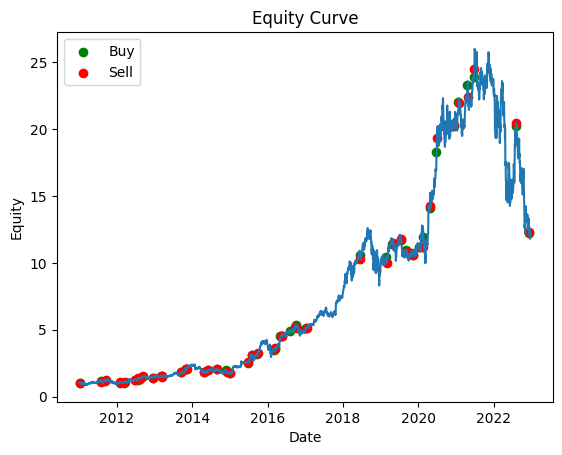

Cumulative Returns: -0.12045360852970043
Maximum Drawdown: -3.731517915047971
Sharpe Ratio: 0.8004482051889372


In [36]:
# Plot equity curve
equity_curve = np.cumprod(1 + np.array(returns))
plt.plot(df.index[1:len(equity_curve)+1], equity_curve)

buy_indices = np.where(df.index.isin(buy_dates))[0]
sell_indices = np.where(df.index.isin(sell_dates))[0]

# Adjust the sell indices to match the length of the equity curve
sell_indices = sell_indices[sell_indices < len(equity_curve)]

plt.scatter(df.index[buy_indices], equity_curve[buy_indices], color='green', label='Buy')
plt.scatter(df.index[sell_indices], equity_curve[sell_indices], color='red', label='Sell')


plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.show()

# Print evaluation metrics
print('Cumulative Returns:', cumulative_returns)
print('Maximum Drawdown:', max_drawdown)
print('Sharpe Ratio:', sharpe_ratio)
